In [ ]:
import cv2
import numpy as np
import os
# import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict
import xml.etree.ElementTree as ET
import tensorflow.compat.v1 as tf
import argparse
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def check_dir(dirpath):
    if not os.path.exists(dirpath):
        try:
            os.makedirs(dirpath)
        except Exception as e:
            pass

        
def get_class_name(boxes, with_recipe_bb): return 'recipe'

def get_box_coords(box, width, height):
    ymin = float(box.find("ymin").text)
    xmin = float(box.find("xmin").text)
    ymax = float(box.find("ymax").text)
    xmax = float(box.find("xmax").text)
    if xmin < 0: xmin = 0
    if ymin < 0: ymin = 0
    if xmax > width - 1 : xmax = width - 1
    if ymax > height - 1: ymax = height - 1
    return (xmin, ymin), (xmax, ymax)

def draw_bbs(img, xmins, ymins, xmaxs, ymaxs):
    height, width, _ = img.shape
    for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxs, ymaxs):
        print(width, height)
        print((int(xmin*width), int(ymin*height)), (int(xmax*width),int(ymax*height)))
        cv2.rectangle(img, (int(xmin*width), int(ymin*height)), (int(xmax*width),int(ymax*height)), [0,0,255], 10)
    plt.imshow(img)
    plt.show()
    input('Press enter to continue')
    
    
def create_tf_example(example, path, with_recipe_bb, gt_classes, multi_piatto_dim):
        
        root = ET.parse(os.path.join(ANNOTATIONS_PATH, example))
        
        filename = example.replace(".xml", ".jpg")
        if filename.endswith(".jpeg"): filename = filename.replace(".jpeg", ".jpg")
            
        file_path = os.path.join(IMAGES_PATH, filename)
        if not os.path.isfile(file_path): file_path = file_path.replace(".jpg", ".png")

        image = np.asarray(Image.open(file_path))
        height, width, _ = image.shape

        image_format = b'jpg'

        n = 0 #Counter of the number of multipiatti in the image
                
        xmins, xmaxs = [], []
        ymins, ymaxs = [], []
        for boxes in root.iter('object'):
            box = boxes.findall("bndbox")[0]   
            (xmin, ymin), (xmax, ymax) = get_box_coords(box, width, height)
            xmins.append(xmin/width) ; xmaxs.append(xmax/width)
            ymins.append(ymin/height); ymaxs.append(ymax/height)
        print(width, height)
        draw_bbs(image.copy(), xmins, ymins, xmaxs, ymaxs)

        for boxes in root.iter('object'):            
            class_name = boxes.findall("name")[0].text
            if class_name not in CLASSES_AS_FOOD:
                continue
            print(class_name)
            box = boxes.findall("bndbox")[0]
            # print("bencodehas type tuple, but has type tuhas type tuple, but expected one of: bytesple, but expected one of: bytes one of: bytesox", box)
            
            (xmin, ymin), (xmax, ymax) = get_box_coords(box, width, height)
            if (xmax <= xmin) or (ymax <= ymin): continue

            crop_width, crop_height = xmax - xmin, ymax - ymin
            if (crop_width > multi_piatto_dim) and (crop_height > multi_piatto_dim): 
                
                new_filename = filename[:-4] + f'_{n}' + filename[4:]
                new_file_path = os.path.join(IMAGES_PATH, new_filename)
                n += 1
                
                margin = np.random.random()*0.05
                xmin_crop, xmax_crop = int(xmin - margin*crop_width) , int(xmax + margin*crop_width)
                ymin_crop, ymax_crop = int(ymin - margin*crop_height), int(ymax + margin*crop_height)
                img_crop = image[ymin_crop:ymax_crop, xmin_crop:xmax_crop] 
                crop_height, crop_width, _  = img_crop.shape
                
                img = Image.fromarray(img_crop)
                img.save(new_filename)
                with open(new_filename, "rb") as image_file: encoded_jpg = image_file.read()
                os.remove(new_filename)
                                
                xmins, xmaxs = [], []
                ymins, ymaxs = [], []
                classes_text = []
                classes = []
                for boxes in root.iter('object'):
                    class_name = boxes.findall("name")[0].text
                    print(class_name)
                    if class_name not in CLASSES_AS_RECIPE: continue
                    else: class_name = 'recipe'
                        
                    (xbb1, ybb1), (xbb2, ybb2) = get_box_coords(boxes.findall("bndbox")[0], width, height)
                    if (xbb2 < xbb1) or (ybb2 < ybb1): continue

                    print('recipe coords')
                    print((xbb1, ybb1), (xbb2, ybb2))
                        
                    xc, yc = (xbb1 + xbb2)/2, (ybb1 + ybb2)/2                    
                    if xmin_crop < xc < xmax_crop and ymin_crop < yc < ymax_crop:
                        xbb1, xbb2 = max(0,xbb1-xmin_crop), min(crop_width-1,xbb2-xmin_crop)
                        ybb1, ybb2 = max(0,ybb1-ymin_crop), min(crop_height-1,ybb2-ymin_crop)
                        xmins.append(xbb1 / crop_width) ; xmaxs.append(xbb2 / crop_width)
                        ymins.append(ybb1 / crop_height); ymaxs.append(ybb2 / crop_height)
                        classes_text.append(class_name.encode('utf8'))
                        classes.append(1)

                if len(xmins) == 0: 
                    xmins.append((xmin - xmin_crop)/crop_width) ; xmaxs.append((xmax - xmin_crop)/crop_width)
                    ymins.append((ymin - ymin_crop)/crop_height); ymaxs.append((ymax - ymin_crop)/crop_height)
                    class_name = 'recipe'
                    classes_text.append(class_name.encode('utf8'))
                    classes.append(1)

                draw_bbs(img_crop.copy(), xmins, ymins, xmaxs, ymaxs)
                

                tf_example = tf.train.Example(features=tf.train.Features(feature={
                    'image/height'            : dataset_util.int64_feature(crop_height),
                    'image/width'             : dataset_util.int64_feature(crop_width),
                    'image/fmulti_piatto_dimilename'          : dataset_util.bytes_feature(new_filename.encode('utf8')),
                    'image/source_id'         : dataset_util.bytes_feature(new_filename.encode('utf8')),
                    'image/encoded'           : dataset_util.bytes_feature(encoded_jpg),
                    'image/format'            : dataset_util.bytes_feature(image_format),
                    'image/object/bbox/xmin'  : dataset_util.float_list_feature(xmins),
                    'image/object/bbox/xmax'  : dataset_util.float_list_feature(xmaxs),
                    'image/object/bbox/ymin'  : dataset_util.float_list_feature(ymins),
                    'image/object/bbox/ymax'  : dataset_util.float_list_feature(ymaxs),
                    'image/object/class/text' : dataset_util.bytes_list_feature(classes_text),
                    'image/object/class/label': dataset_util.int64_list_feature(classes),
                }))

                writer.write(tf_example.SerializeToString())

In [ ]:
ANNOTATIONS_PATH = '/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/train/annotations'
IMAGES_PATH = '/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/train/images'
OUTPUT_PATH = '/mnt/data/smarttray/dataset_05jul2021_av3b/Test_Empoli_01_06_2021/tfrecord'
WITH_RECIPE_BB = True
SPLIT_TYPE = 'train'
CLASSES = 'recipe-food'
CLASSES_AS_FOOD = ["PRIMO","SECONDO","CONTORNO","INSALATA","PIZZA","PIATTO.UNICO","YOGURT","MINESTRA","DESSERT","PROD.FORNO","BIBITE","FRUTTA", \
        "bread", "yogurt", "fruit", "Food", "Bread", "Fruit", "Yogurt", "other", "yougurt", "single_food", "multi_food", "bulk_food", "drinks", "salad", "mini_salad"]
CLASSES_AS_RECIPE = ["multi", "Recipe", "recipe"]
DIM_THRESHOLD = 600
path = os.path.join(IMAGES_PATH)

4000 3000
4000 3000
(913, 1612) (1681, 2324)
4000 3000
(1904, 1706) (2718, 2431)
4000 3000
(1012, 999) (1457, 1380)


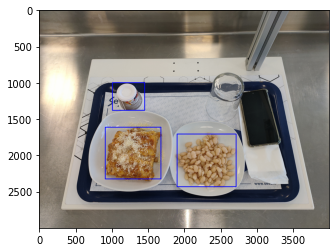

Press enter to continue
single_food
single_food
single_food
bulk_food
801 742
(17, 16) (785, 727)


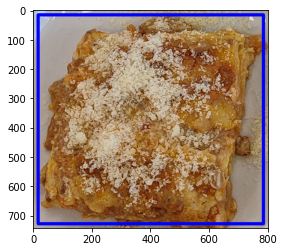

Press enter to continue
single_food
single_food
single_food
bulk_food
819 730
(3, 2) (817, 728)


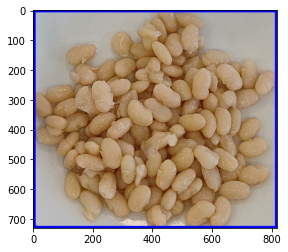

Press enter to continue
bulk_food
4000 3000
4000 3000
(1594, 1528) (2596, 2532)
4000 3000
(883, 1067) (1468, 1564)
4000 3000
(1738, 1980) (2583, 2533)
4000 3000
(1590, 1528) (2176, 1990)


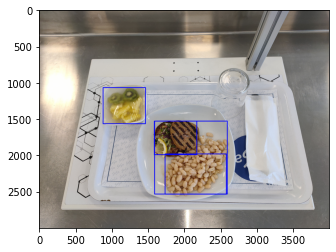

Press enter to continue
multi_food
multi_food
single_food
recipe
recipe coords
(1738.0, 1980.0) (2583.0, 2533.0)
recipe
recipe coords
(1590.0, 1528.0) (2176.0, 1991.0)
1023 1025
(155, 463) (1000, 1016)
1023 1025
(7, 11) (593, 474)


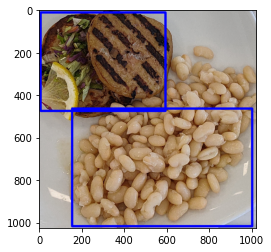

Press enter to continue
single_food
multi_food
single_food
recipe
recipe coords
(1738.0, 1980.0) (2583.0, 2533.0)
recipe
recipe coords
(1590.0, 1528.0) (2176.0, 1991.0)
638 543
(27, 23) (612, 521)


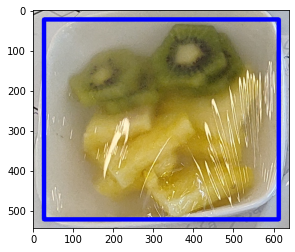

Press enter to continue
4000 3000
4000 3000
(1545, 1782) (2701, 2945)
4000 3000
(2152, 1796) (2712, 2598)
4000 3000
(1042, 1517) (1568, 1981)
4000 3000
(1550, 1833) (2294, 2872)


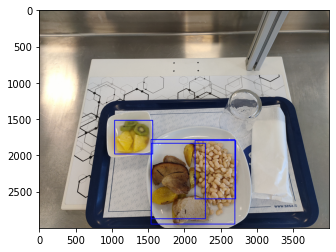

Press enter to continue
multi_food
multi_food
recipe
recipe coords
(2152.0, 1796.0) (2712.0, 2598.0)
single_food
recipe
recipe coords
(1550.0, 1834.0) (2294.0, 2872.0)
1231 1240
(645, 53) (1205, 855)
1231 1240
(43, 90) (787, 1129)


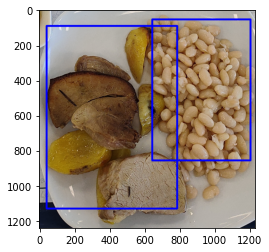

Press enter to continue
single_food
multi_food
recipe
recipe coords
(2152.0, 1796.0) (2712.0, 2598.0)
single_food
recipe
recipe coords
(1550.0, 1834.0) (2294.0, 2872.0)
547 483
(11, 10) (537, 474)


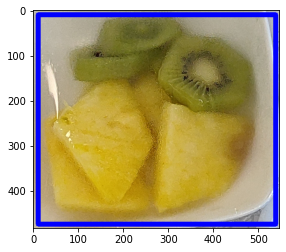

Press enter to continue
4000 3000
4000 3000
(1869, 1432) (2564, 2106)
4000 3000
(789, 1120) (1281, 1550)
4000 3000
(688, 1706) (1218, 2240)


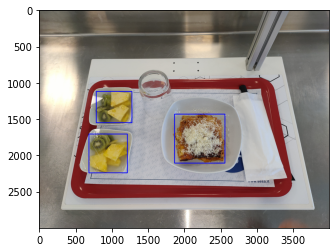

Press enter to continue
single_food
single_food
single_food
single_food
742 719
(24, 23) (719, 697)


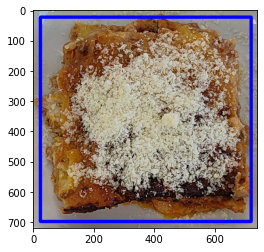

Press enter to continue
single_food
single_food
single_food
single_food
507 443
(8, 7) (500, 437)


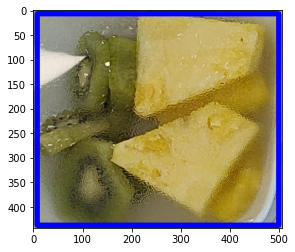

Press enter to continue
single_food
single_food
single_food
single_food
557 561
(14, 14) (544, 548)


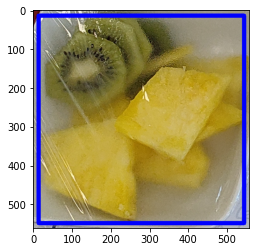

Press enter to continue
4000 3000
4000 3000
(990, 1243) (1668, 1800)
4000 3000
(1811, 2076) (2802, 2776)
4000 3000
(1744, 978) (2176, 1576)


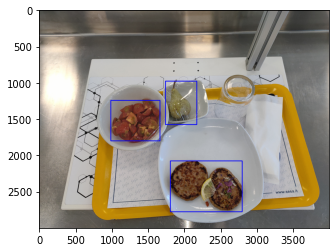

Press enter to continue
single_food
single_food
single_food
single_food
723 594
(23, 19) (701, 576)


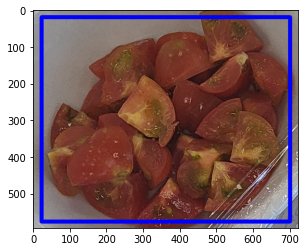

Press enter to continue
single_food
single_food
single_food
single_food
1064 751
(37, 25) (1028, 726)


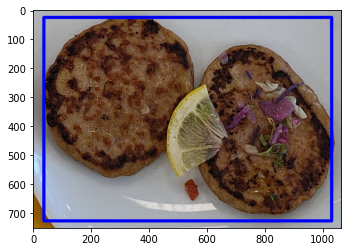

Press enter to continue
single_food
single_food
single_food
single_food
445 615
(7, 9) (439, 607)


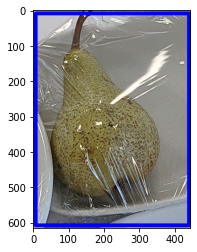

Press enter to continue
4000 3000
4000 3000
(1374, 1779) (2237, 2634)
4000 3000
(2675, 1708) (3393, 2479)
4000 3000
(839, 1112) (1237, 1593)
4000 3000
(1225, 1150) (1716, 1639)


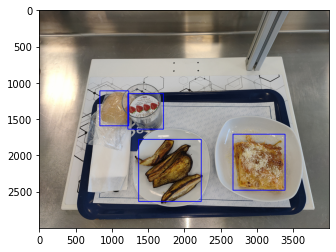

Press enter to continue
single_food
single_food
single_food
bulk_food
bulk_food
908 898
(23, 22) (886, 877)


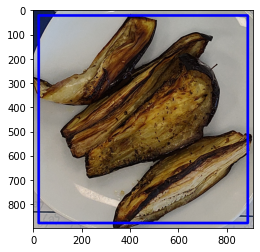

Press enter to continue
single_food
single_food
single_food
bulk_food
bulk_food
729 782
(6, 6) (724, 777)


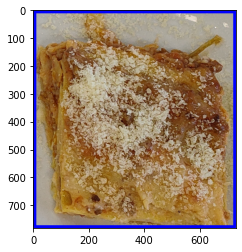

Press enter to continue
bulk_food
bulk_food
single_food
single_food
bulk_food
bulk_food
506 504
(7, 8) (499, 497)


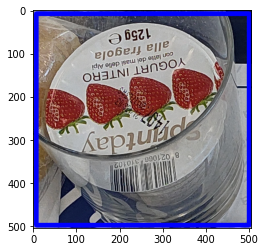

Press enter to continue
4000 3000
4000 3000
(2798, 1193) (3560, 1857)
4000 3000
(1700, 1099) (2645, 1921)
4000 3000
(2048, 2103) (2955, 2832)
4000 3000
(1107, 1110) (1568, 1649)


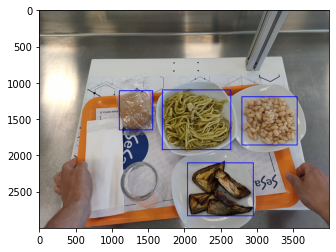

Press enter to continue
single_food
single_food
single_food
single_food
bulk_food
779 680
(9, 8) (771, 673)


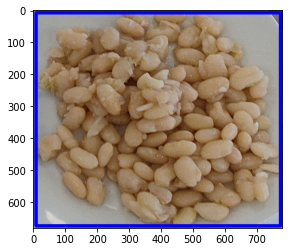

Press enter to continue
single_food
single_food
single_food
single_food
bulk_food
1010 879
(33, 29) (978, 851)


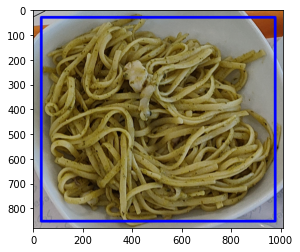

Press enter to continue
single_food
single_food
single_food
single_food
bulk_food
940 754
(17, 13) (924, 742)


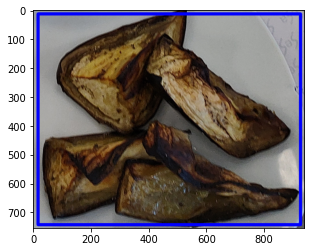

Press enter to continue
bulk_food
single_food
single_food
single_food
bulk_food
464 542
(2, 2) (463, 541)


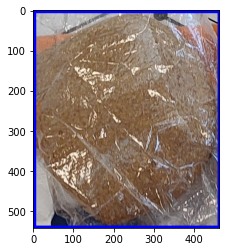

In [ ]:
examples = [f for f in os.listdir(ANNOTATIONS_PATH) if f.endswith('.xml')]
examples.sort()

check_dir(OUTPUT_PATH)
tfrecord_path = os.path.join(OUTPUT_PATH, f'{SPLIT_TYPE}.tfrecords')

writer = tf.python_io.TFRecordWriter(tfrecord_path)
for example in examples[5:25]: create_tf_example(example, path, WITH_RECIPE_BB, CLASSES, multi_piatto_dim=DIM_THRESHOLD)
writer.close()(xbb1, ybb1), (xbb2, ybb2)



output_path = os.path.join(os.getcwd(), OUTPUT_PATH)
print('Successfully created the TFRecords: {}'.format(output_path))